# 4. Desarrollo del modelo propuesto

Esta sección presenta el diseño, entrenamiento y evaluación del modelo ensamblado propuesto: **SD-GBClassifier (Stacked Dengue - Gradient Boosting Classifier)**. Esta solución integra modelos base complementarios (Random Forest y XGBoost) mediante un meta-modelo Gradient Boosting, priorizando la sensibilidad en la detección de casos positivos.

## 4.1  Motivación del modelo ensamblado

Tras la evaluación comparativa, se identificó que los modelos _Random Forest_ y _XGBoost_ ofrecían los mejores resultados individuales en términos de recall y F1-score. Sin embargo, los falsos negativos siguen siendo mayores al 20% de los reales positivos, además cada uno trabaja con sesgos diferentes, RF captura mejor las interacciones no lineales, mientras que XGB solo optimiza el gradiente, por tanto, se evaluó la posibilidad de mejorar el rendimiento general mediante un modelo ensamblado.

El enfoque adoptado fue el de **stacking**, el cual permite combinar múltiples clasificadores base y utilizar un modelo final (meta-modelo) que aprende a integrarlos. Esta estrategia tiene el potencial de corregir los errores de los clasificadores individuales y aprovechar sus fortalezas de forma conjunta, como la robustez ante el ruido de RF y el manejo optimo de desbalance.

El objetivo es lograr una mayor sensibilidad en la detección de casos confirmados de dengue, minimizando falsos negativos (lo más cercano a 20%) mediante la combinación inteligente de predictores complementarios.

## 4.2 Estructura del modelo propuesto

In [1]:
# Librerías

# Estándar
import time
import os 
import joblib
import warnings
os.environ["LOKY_MAX_CPU_COUNT"] = "8" 

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento
import numpy as np
import pandas as pd

# Adicionales
import time
from lime.lime_tabular import LimeTabularExplainer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Librerías de modelado

# Procesamiento de datos
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')
from sklearn.calibration import CalibratedClassifierCV

# Division de datos
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV)

# Modelos de clasificación
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier, 
    GradientBoostingClassifier, VotingClassifier)
from xgboost import XGBClassifier


# Evaluación de modelos
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score, auc, 
    f1_score,
    precision_recall_curve, recall_score, average_precision_score)

# Balanceo
from imblearn.over_sampling import SMOTE

### 4.2.1 Ajuste de variables y división de los datos

In [3]:
# Lectura de datos
df = pd.read_csv(r"C:\Users\Hp\MACHINE\data\registros_dengue.csv")
df = df.drop(columns=['TIP_CAS'])

# Ajuste de edades menores a un año 
# (Representación de en días, semanas o meses, variable que representa años)
df.loc[df["EDAD_AJUSTADA"] < 1, "EDAD_AJUSTADA"] = 1 
df.loc[df["EDAD_AJUSTADA"] > 114, "EDAD_AJUSTADA"] = np.nan

# Reemplazo de NA en la variable EDAD_AJUSTADA por la mediana de la variable
mediana_eda = df['EDAD_AJUSTADA'].median()
df.loc[:, 'EDAD_AJUSTADA'] = df['EDAD_AJUSTADA'].fillna(mediana_eda)

# ajuste de tipos de datos
df.loc[:,'EDAD_AJUSTADA'] = df['EDAD_AJUSTADA'].astype('int64')

In [4]:
# Codificación One-Hot para las variables categóricas 
# 'TIP_SS' (Tipo aseguradora) y 'EVENTO'
# Se usa drop_first=True para evitar multicolinealidad eliminando la primera categoría
df = pd.get_dummies(df, columns=['TIP_SS', 'EVENTO'], drop_first=True)

# Transformación de 'PAIS_OCU', 'DPTO_OCU' y 'MUN_OCU' a valores de frecuencia relativa
# Se reemplazan las categorías por la proporción de ocurrencias en el dataset
for col in ['PAIS_OCU', 'DPTO_OCU', 'MUN_OCU']:
    freq = df[col].value_counts(normalize=True).to_dict()
    df[col] = df[col].map(freq).fillna(0).astype('float64')

# Normalización de la variable numérica 'EDAD_AJUSTADA'
# Se estandariza para que tenga media 0 y desviación estándar 1
scaler = StandardScaler()
df['EDAD_AJUSTADA'] = scaler.fit_transform(df[['EDAD_AJUSTADA']])

Se utilizó una división estratificada con `random_state=42` para garantizar reproducibilidad, asignando el 70% para entrenamiento y el 30% para prueba.

In [5]:
# División de conjuntos de datos

# Definir variable predictora y objetivo
X = df.drop(columns=['CONFIRMADOS'])
y = df['CONFIRMADOS'] 

# Division en train y test (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, random_state=42, stratify=y)

# Verificación de la división
print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Test: {y_test.shape}")

Train: (663096, 19), Test: (284184, 19)
Train: (663096,), Test: (284184,)


### 4.2.2 Búsqueda de los mejores hiperparámetros para los modelos base

Se utilizó `RandomizedSearchCV` con 5 folds y 10 iteraciones, con métrica de evaluación _recall_ para ajustar los modelos base:
- `RandomForestClassifier`
- `XGBClassifier`


In [6]:
# Random Forest
# Uso de peso de clases balanceado
modelo_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', 0.5],
    'max_samples': [0.8, 0.9]
}

In [7]:
grid = RandomizedSearchCV(modelo_rf, param_distributions=param_grid_rf, 
                    n_iter=10, cv=5, scoring='recall', n_jobs=-1, verbose=2,
                    random_state=42)

```
Evaluando Random Forest
Random Search
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tiempo de fit: 89.55 minutos
Mejores parámetros: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8, 'max_features': 0.5, 'max_depth': 20}
```


In [8]:
# XGBoost
# Escalamiento a partir del valor real de las clases
modelo_XGB = XGBClassifier(
    scale_pos_weight=403716 / 543564, 
    eval_metric='logloss', random_state=42)
param_grid_xgb = {
    'max_depth': [4, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}


In [9]:
grid = RandomizedSearchCV(modelo_XGB, param_distributions=param_grid_xgb, 
                    n_iter=10, cv=5, scoring='recall', n_jobs=-1, verbose=2,
                    random_state=42)

````
Evaluando XGBoost
Random Search
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tiempo de fit: 4.72 minutos
Mejores parámetros: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

### 4.2.3 Evaluación individual de modelos base

Se entrenaron los modelos base con sus mejores parámetros y se evaluaron usando recall, F1-Score, AUC, matriz de confusión y tiempo de entrenamiento.

In [10]:
best_rf = RandomForestClassifier(
        n_estimators = 100, 
        min_samples_split = 5,
        min_samples_leaf = 2, 
        max_samples = 0.8, 
        max_features = 0.5, 
        max_depth = 20)

````
--- RF ---
Entrenando...
Tiempo de fit: 2.13 minutos
Modelo guardado en RF.pkl
---Train---
Recall:   0.8753
---Test---
Recall:   0.8162
F1 Score: 0.7729
ROC AUC:  0.8556
              precision    recall  f1-score   support

           0       0.74      0.72      0.73    121115
           1       0.79      0.82      0.81    163069

    accuracy                           0.77    284184
   macro avg       0.77      0.77      0.77    284184
weighted avg       0.77      0.77      0.77    284184

TP: 133101, FP: 34409, TN: 86706, FN: 29968


Al refinar el modelo de _Random Forest_ y entrenarlo sobre un la nueva división de datos, se obtuvo un rendimiento notablemente superior al observado en la evaluación inicial. El recall en test aumentó a **0.8162**, el F1 score a 0.7729, y el ROC AUC alcanzó 0.8556, consolidando a Random Forest como el modelo con mejor capacidad predictiva entre todos los evaluados. 

Además, presenta un buen equilibrio entre precisión y sensibilidad en ambas clases, con una precisión del 79% y un recall del 82% en la clase positiva. En términos absolutos, el modelo obtuvo una cantidad considerablemente baja de falsos negativos **(29,968)** solo el **18.4%** del total de casos positivos, obteniendo asi un **81.6%** de verdaderos positivos **(133,101)**, lo cual indica que el modelo logra identificar correctamente la mayoría de los casos positivos, incluso por debajo del umbral esperado para el error propuesto en este trabajo.

In [11]:
best_XGB =  XGBClassifier(
        learning_rate=0.05,
        max_depth=6,
        n_estimators=300,
        eval_metric='logloss',
        subsample = 0.8,
        gamma = 1,
        scale_pos_weight=403716 / 543564,
        colsample_bytree = 1.0,
        random_state=42,
        n_jobs=-1)

````
--- XGB ---
Entrenando...
Tiempo de fit: 0.12 minutos
Modelo guardado en XGB.pkl
---Train---
Recall:   0.7124
---Test---
Recall:   0.7104
F1 Score: 0.7453
ROC AUC:  0.8307
              precision    recall  f1-score   support

           0       0.67      0.79      0.72    121115
           1       0.82      0.71      0.76    163069

    accuracy                           0.74    284184
   macro avg       0.74      0.75      0.74    284184
weighted avg       0.76      0.74      0.75    284184

TP: 115841, FP: 25552, TN: 95563, FN: 47228

El modelo _XGBoost_ mostró un desempeño sólido, con un *recall* en test de **0.7104**, un F1 score de 0.7453 y un ROC AUC de 0.8307. Con una precisión del 82% en la clase positiva y un recall del 71%, demuestra una alta capacidad para detectar correctamente los casos positivos. EL modelo logró identificar correctamente La matriz de confusión respalda estos resultados: se identificaron correctamente **115,841 verdaderos positivos (71%)**, con **47,228 falsos negativo (29%)** , lo cual evidencia un bajo nivel de alarmas falsas. Su rendimiento competitivo y su bajo tiempo de entrenamiento (solo 0.12 minutos) lo convierten en una alternativa eficiente y confiable.


### 4.2.4 Evaluación de GradientBoosting Classifier como meta modelo

Se probaron múltiples configuraciones para el modelo ensamblado con el fin de encontrar la combinación óptima:

- `VotingClassifier`: combinación directa de Random Forest y XGBoost mediante soft voting.
- `StackingClassifier` con `LogisticRegression` como meta-modelo.
- `StackingClassifier` calibrado con `CalibratedClassifierCV`.
- `GradientBoostingClassifier` como meta-modelo.


| Modelo                       | Recall | F1 Score | AUC   | Tiempo |
|-----------------------------|--------|----------|-------|--------|
| VotingClassifier            | 0.773  | 0.769    | 0.851 | 2.04 min  |
| Stacking (LogReg)           | 0.76  | 0.770    | 0.854 | 18.55 min  |
| Stacking (VotingClassifier + GB) | 0.8107 | 0.769 | 0.85 | 6.38 min|
| Stacking (Calibrated)       | 0.81  | 0.773    | 0.855 | 28.72 min |
| Stacking (Base + GB)   | 0.827  | 0.772    | 0.854 | 11.41 min ✅ |

Se concluye que el uso de `GradientBoostingClassifier` como meta-modelo, junto con `passthrough=True`, ofrece el mejor desempeño general. 

### 4.2.5 Construcción del modelo 

El modelo propuesto es un ensamblado jerárquico (stacking), que combina técnicas bagging y boosting compuesto por:

- **Modelos base**:
  - `RandomForestClassifier`
  - `XGBClassifier`

- **Meta-modelo**:
  - `GradientBoostingClassifier`

Se empleó la configuración `passthrough=True`, lo cual permite al meta-modelo acceder no solo a las predicciones de los clasificadores base, sino también a las variables originales, lo que facilita la detección de interacciones residuales útiles para mejorar la predicción.

In [12]:
# Define base models
base_learners = [
    ('xgb', best_XGB),
    ('rf', best_rf)
]

In [13]:
# Meta modelo con los mejores hiperparámetros
meta_model_gb = GradientBoostingClassifier(
    subsample=1.0,
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=3,
    max_depth=2,
    learning_rate=0.01,
    random_state=42)

In [14]:
# Stacking: BaseLearners + GradientBoosting (passthrough=True)
model = StackingClassifier(
    estimators=base_learners,  
    final_estimator=meta_model_gb,
    stack_method='predict_proba',
    passthrough=True,
    n_jobs=-1
)

```{note}
Para este modelo no se requirió el uso de reducción de dimensionalidad PCA, dado que los modelos base tienen alta capacidad de aprendizaje.

## 4.3 Entrenamiento y evaluación

### 4.3.1 Métricas del modelo final

Se presentan las métricas clave del modelo ensamblado propuesto, evaluadas sobre el conjunto de prueba.

In [15]:
# Análisis modelo
print("--- Modelo propuesto ---")
# Modelo seleccionado
start_time = time.time()
model.fit(X_train, y_train)
fin_time = time.time() - start_time
print(f"Tiempo de fit: {fin_time/60:.2f} minutos")

--- Modelo propuesto ---


OSError: [Errno 22] Invalid argument

````
--- Modelo propuesto ---
Tiempo de fit: 6.74 minutos

In [14]:
print("Métricas del modelo propuesto")
print("\n ---Train---")
y_train_pred = model.predict(X_train)
print("Recall:  ", round(recall_score(y_train, y_train_pred), 4))
print("F1 Score:", round(f1_score(y_train, y_train_pred, average='weighted'),4))
print("ROC AUC: ", round(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),4))

print("\n ---Test---")
y_pred = model.predict(X_test)
print("Recall:  ", round(recall_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred, average='weighted'),4))
print("ROC AUC: ", round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),4))

print("\n ---Reporte de clasificación---")
print(classification_report(y_test, y_pred))

Métricas del modelo propuesto

 ---Train---
Recall:   0.884
F1 Score: 0.8434
ROC AUC:  0.9285

 ---Test---
Recall:   0.8259
F1 Score: 0.7725
ROC AUC:  0.8543

 ---Reporte de clasificación---
              precision    recall  f1-score   support

           0       0.75      0.70      0.73    121115
           1       0.79      0.83      0.81    163069

    accuracy                           0.77    284184
   macro avg       0.77      0.76      0.77    284184
weighted avg       0.77      0.77      0.77    284184



El modelo _SD-GBClassifier propuesto_ demuestra un rendimiento robusto y balanceado, posicionándose como uno de los mejores entre los evaluados. En el conjunto de prueba, alcanzó un recall de **0.8259**, un F1 score de **0.7725** y un ROC AUC de **0.8543**, lo cual indica una buena capacidad tanto para detectar positivos como para mantener un bajo nivel de falsos positivos. El reporte de clasificación muestra una precisión del 79% para la clase positiva (1) y un recall del 83%, lo que refleja una fuerte habilidad del modelo para captar correctamente los casos relevantes. Aunque la clase negativa (0) presenta un recall más bajo (70%), el equilibrio global es adecuado, con una accuracy general del 77%. Además, el alto ROC AUC en entrenamiento (0.9285) y su cercanía al de prueba sugiere que el modelo generaliza bien sin sobreajustarse. 

> Esta arquitectura de modelo ensamblado fue seleccionada por su capacidad de *maximizar el recall* en la detección de casos confirmados de dengue, es decir, maximiza la detección de casos verdaderos positivos, lo cual es prioritario en contextos de salud pública, donde se quiere minimizar la cantidad de casos falsos negativos. 

### 4.3.2 Matriz de confusión

La matriz de confusión compara las predicciones del modelo con los valores reales de un conjunto de datos, en el contexto de este trabajo los valores obtenidos se interpretan de la siguiente manera:

- **TP**: Casos positivos correctamente identificados.
- **FN**: Casos positivos no detectados (críticos).
- **FP**: Casos negativos mal clasificados como positivos.
- **TN**: Casos negativos correctamente descartados.

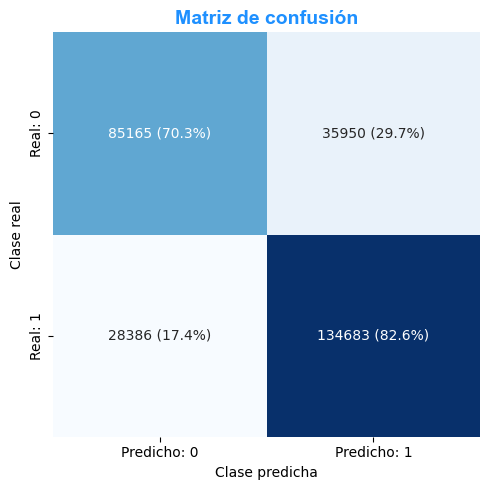

In [23]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # proporciones por fila

labels = np.array([
    [f'{cm[0,0]} ({cm_norm[0,0]*100:.1f}%)', f'{cm[0,1]} ({cm_norm[0,1]*100:.1f}%)'],
    [f'{cm[1,0]} ({cm_norm[1,0]*100:.1f}%)', f'{cm[1,1]} ({cm_norm[1,1]*100:.1f}%)']
])

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=['Predicho: 0', 'Predicho: 1'],
            yticklabels=['Real: 0', 'Real: 1'])
plt.title('Matriz de confusión', fontsize=14, color='dodgerblue', fontname='Arial', fontweight='bold')
plt.ylabel('Clase real')
plt.xlabel('Clase predicha')
plt.tight_layout()
plt.show()


El modelo _SD-GBClassifier propuesto_ demuestra ser especialmente adecuado para el contexto del estudio, centrado en la **confirmación de casos de dengue**, donde es crucial maximizar el recall con el fin de minimizar los falsos negativos. 

En aplicaciones clínicas y epidemiológicas, omitir un caso positivo puede tener consecuencias críticas, debido a que implica no tratar adecuadamente a una persona contagiada. 

El modelo alcanza un recall del **82.6%** en el conjunto de prueba, detectando correctamente **134,683 (82.5%)** casos positivos (TP), y reduciendo los falsos negativos a solo **28,386** casos, lo que representa apenas el **17.4%** de los casos reales positivos. En contraste, los verdaderos negativos (TN) fueron 85,165 (el 70.3% de los negativos reales), mientras que los falsos positivos (FP) fueron 35,950 (el 29.7% de los negativos reales).

Estos resultados reflejan un buen equilibrio entre sensibilidad y precisión, con una adecuada capacidad de discriminación general (AUC = 0.8543).

En conjunto, estas características posicionan al modelo como una herramienta eficaz para apoyar decisiones clínicas y de vigilancia epidemiológica en entornos sensibles a errores de tipo II.

### 4.3.2. Curvas de rendimiento

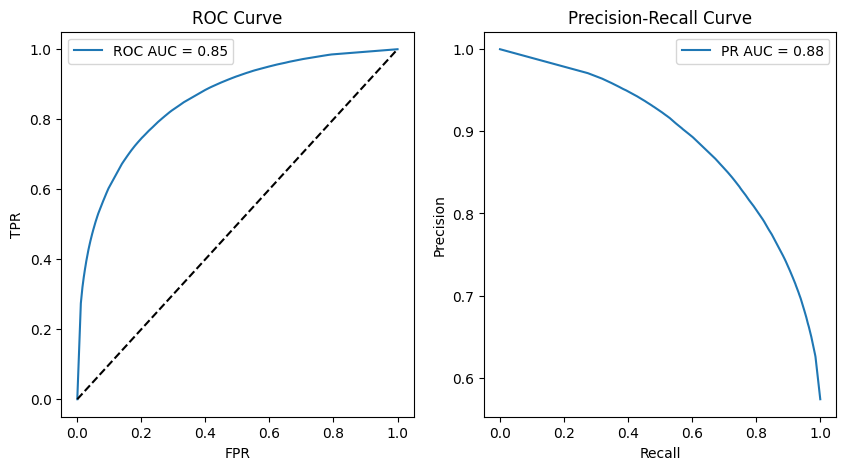

In [31]:
y_scores = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)

plt.subplot(1,2,2)
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

In [25]:
def plot_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    for name, model in models.items():
        probas = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, probas)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    for name, model in models.items():
        probas = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, probas)
        plt.plot(recall, precision, label=name)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [28]:
best_rf= joblib.load("RF.pkl")
best_XGB= joblib.load("XGB.pkl")


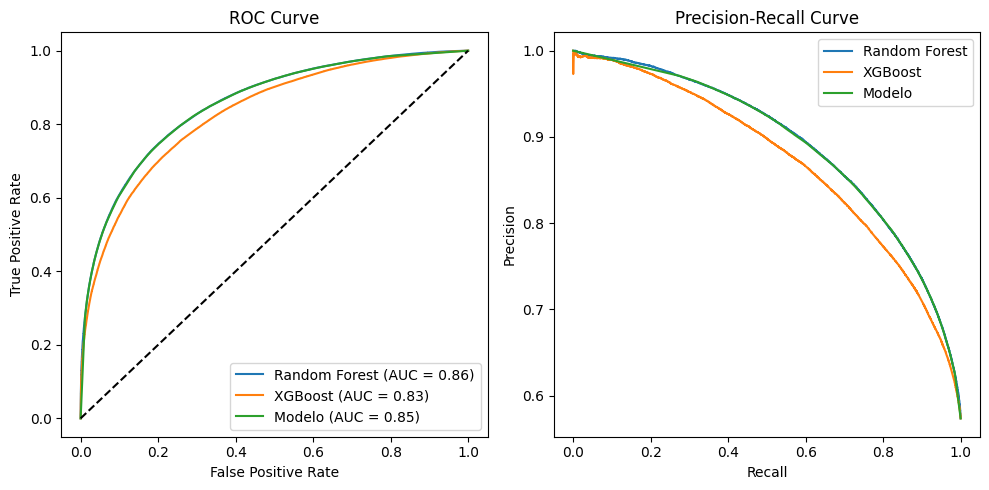

In [29]:
models = {
    "Random Forest": best_rf,
    "XGBoost": best_XGB,
    "Modelo": model
}

plot_curves(models, X_test, y_test)

Al comparar el modelo _SD-GBClassifier propuesto_ con Random Forest y XGBoost, se observa que Random Forest tiene una ligera ventaja en el AUC de la curva ROC (0.86 vs. 0.85 del _SD-GBClassifier propuesto_ y 0.83 de XGBoost). Sin embargo, en la curva de precisión-recall, _SD-GBClassifier propuesto_ se destaca, superando levemente a ambos competidores. 

Esto indica que, aunque otros modelos puedan tener una mejor discriminación general (ROC), el modelo propuesto logra un mejor balance entre precisión y recall cuando se trata de identificar correctamente los casos positivos, lo cual es prioritario en la confirmación de casos de dengue.

### 4.3.3 Análisis de errores por grupo

Se analizó la tasa de error del modelo:

 $$\text{Tasa de error} = \frac{N° errores}{N° total de casos}$$ 

Se presentan variables de interés en los grupos cuya tasa de error supera el 25%.

In [103]:
df_2 = pd.read_csv(r"C:\Users\Hp\MACHINE\data\registros_dengue.csv")
df_2.loc[df["EDAD_AJUSTADA"] < 1, "EDAD_AJUSTADA"] = 1 
df_2.loc[df["EDAD_AJUSTADA"] > 114, "EDAD_AJUSTADA"] = np.nan
mediana_eda = df_2['EDAD_AJUSTADA'].median()
df_2.loc[:, 'EDAD_AJUSTADA'] = df_2['EDAD_AJUSTADA'].fillna(mediana_eda)

df_test = df_2.loc[X_test.index].copy()
df_test['y_true'] = y_test
df_test['y_pred'] = y_pred
df_test['error'] = (y_test != y_pred).astype(int)

# 🔁 Función genérica para graficar tasa de error por variable
def graficar_tasa_error(df_test, var, umbral=0.25, nombre_var=None):
    resumen = df_test.groupby(var)['error'].agg(['mean', 'count']).reset_index()
    resumen = resumen[resumen['mean'] > umbral]  # Filtrar grupos con >25% de error
    resumen = resumen.sort_values('mean', ascending=False)

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=resumen, x=var, y='mean', palette='Reds_r')
    plt.title(f'Tasa de error por grupo: {nombre_var or var} (> {umbral*100:.0f}%)')
    plt.ylabel('Tasa de error')
    plt.xlabel(nombre_var or var)
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

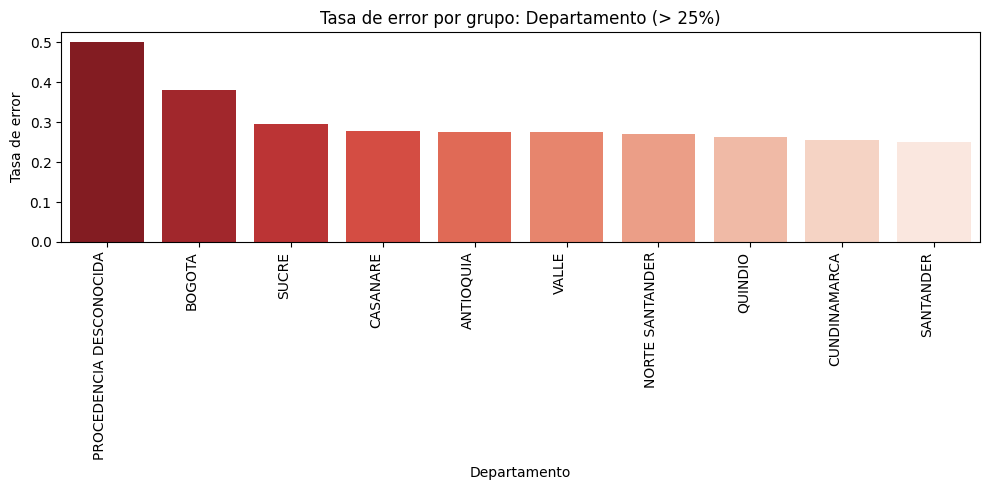

In [104]:
graficar_tasa_error(df_test, 'DPTO_OCU', nombre_var='Departamento')

De los departamentos analizados, los registros de Procedencia Desconocida son los que tienen mayor tasa de error, exactamente 50%. Luego, los departamentos Bogotá (38%), Sucre (29.5%) y Casanare (27.8%) son los tres que presentan las tasas de error más elevadas. Santander tiene la menor tasa de error dentro del grupo seleccionado, (25.1%).

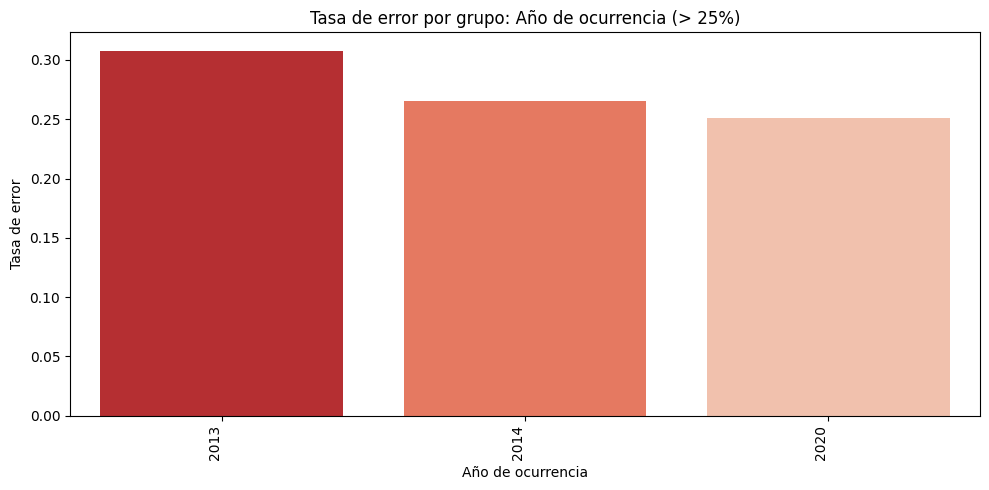

In [105]:
# ✅ 2. Año de ocurrencia
graficar_tasa_error(df_test, 'ANO', nombre_var='Año de ocurrencia')

Con respecto al año de ocurrencia, el modelo tiene una tasa de error mayor para los registros del año 2013 (30.8%), seguido del 2014 con una tasa del 26.5%. Por otra parte el año 2020 tiene una tasa de error también representativa del 25.1%. Este error puede estar relacionado con la calidad de datos recolectados en los primeros años, y durante la pandemia del covid-19.

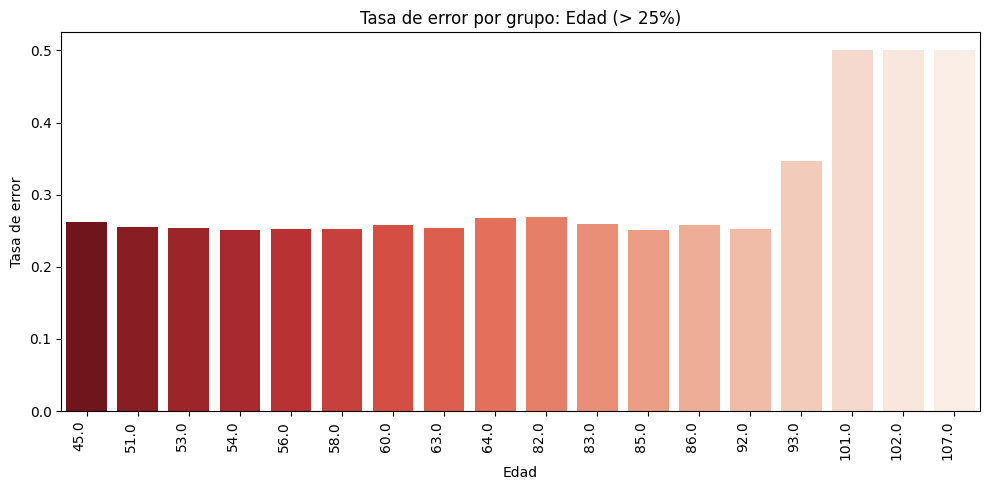

In [109]:
graficar_tasa_error(df_test, 'EDAD_AJUSTADA', nombre_var='Edad')

En cuanto a los grupos etarios el modelo falla en mayor medida para los registros de pacientes mayores a 45 años, en edades entre los 50's, 60's, 80's y más de 100 años, grupo en el cual la tasa de error es del 50%. 

<Axes: title={'center': 'Tasa de error por hospitalización'}, xlabel='PAC_HOS'>

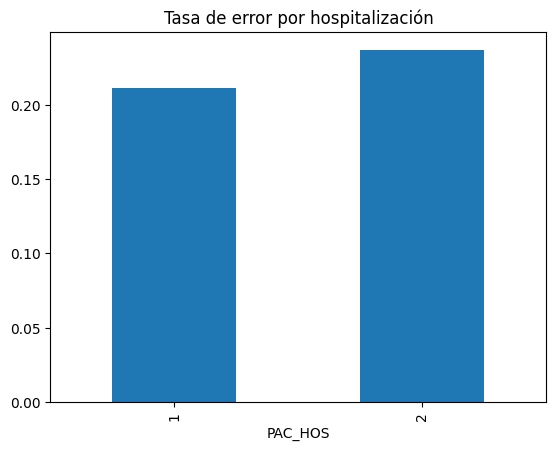

In [115]:
# Ejemplo: tasa de error por PAC_HOS
df["error"] = (y_test != y_pred).astype(int)
error_pac = df.groupby("PAC_HOS")["error"].mean()
error_pac.plot(kind='bar', title="Tasa de error por hospitalización")


En cuanto a la tasa de error por hospitalización, el modelo falla más en los pacientes no hospitalizados.

### 4.3.4 Evaluación de la calibración del modelo
Se incluyó la curva de calibración del modelo para evaluar la confiabilidad de las probabilidades estimadas.

La curva de calibración compara las predicciones del modelo con las frecuencias observadas, si sigue la linea $y=x$, el modelo esta bien calibrado, si la curva está por encima, indica sobreestimación de probabilidades, mientras si está por debajo las subestima. 

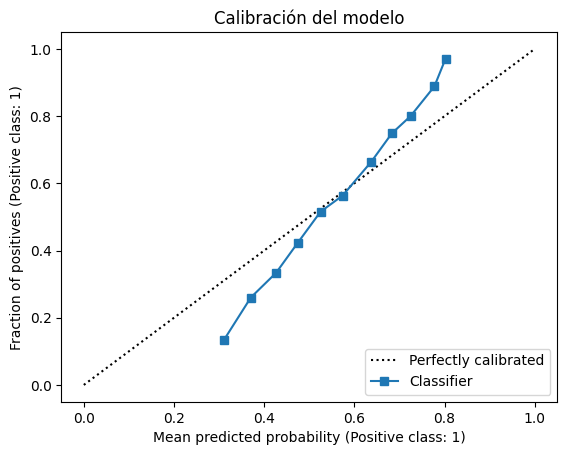

In [120]:
from sklearn.calibration import CalibrationDisplay

# Probabilidades
probas = model.predict_proba(X_test)[:, 1]
CalibrationDisplay.from_predictions(y_test, probas, n_bins=20)
plt.title("Calibración del modelo")
plt.show()


La curva de calibración evidencia para el modelo _SD-GBClassifier propuesto_  lo siguiente:

* En el rango intermedio de probabilidades (aproximadamente entre **0.5 y 0.75**), el modelo muestra una calibración muy cercana a la ideal, lo que indica que sus predicciones de riesgo son confiables y coherentes con la realidad observada.

* En los rangos más bajos (por debajo de 0.5), el modelo presenta una ligera subcalibración, es decir, tiende a subestimar la probabilidad de un caso positivo. Esto sugiere que algunos casos positivos podrían estar recibiendo puntuaciones de riesgo más bajas de lo esperado.

* En el rango superior (> 0.75), se evidencia una leve sobrecalibración positiva: los casos con alta probabilidad asignada por el modelo tienen una frecuencia real aún mayor de ser positivos. Esto implica que el modelo es conservador en sus predicciones más seguras, lo cual puede ser clínicamente útil para priorizar los casos más graves o evidentes.

En resumen, el modelo  muestra un buen nivel de calibración general, lo que permite confiar en las probabilidades predichas como estimaciones válidas del riesgo real de ser un caso confirmado de dengue.

## 4.4 Importancia y explicabilidad



### 4.4.1 Importancia de características en los modelos base
A continuación se presentan las variables más relevantes identificadas por cada modelo base, se usa `feature_importances_` para destacar las 5 características más importantes por modelo.

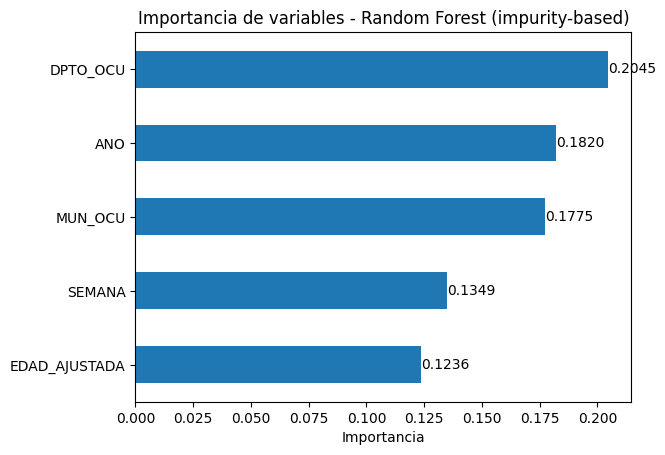

In [128]:
# Accede al modelo base desde el stacking ya entrenado
rf_model = model.named_estimators_['rf']

# Importancia de variables
importancia_rf = rf_model.feature_importances_
features_rf = X_train.columns  # Asegúrate de que X_train sea un DataFrame

# Crear Series con nombres
importancias_rf_series = pd.Series(importancia_rf, index=features_rf).sort_values(ascending=False)

# Mostrar gráfico
importancias_rf_series.head(5).plot(kind='barh')
plt.title("Importancia de variables - Random Forest (impurity-based)")
for i, v in enumerate(importancias_rf_series.head(5)):
    plt.text(v, i, f"{v:.4f}", ha='left', va='center')

plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.show()

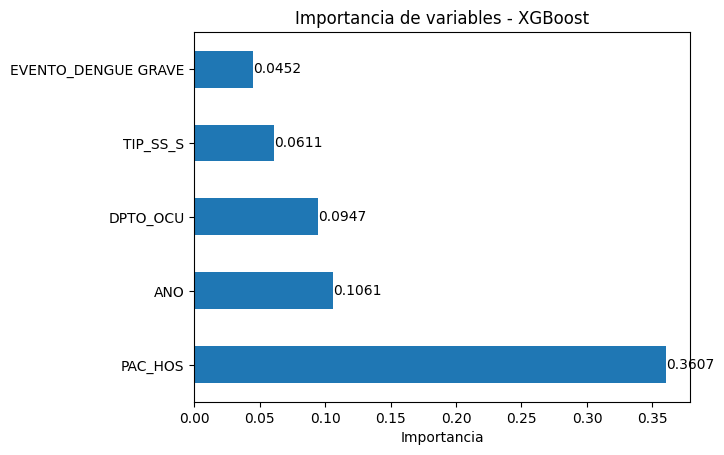

In [138]:
# Accede al modelo base desde el stacking ya entrenado
xgb_model = model.named_estimators_['xgb']

# Importancia de variables
importancia_xgb = xgb_model.feature_importances_
features_xgb = X_train.columns
importancias_xgb_series = pd.Series(importancia_xgb, index=features_xgb).sort_values(ascending=False)

# Mostrar gráfico
importancias_xgb_series.head(5).plot(kind='barh')
plt.title("Importancia de variables - XGBoost")
plt.xlabel("Importancia")
for i, v in enumerate(importancias_xgb_series.head(5)):
    plt.text(v, i, f"{v:.4f}", ha='left', va='center')

plt.show()

Para los modelos base, las características relacionadas al departamento, el municipio, el año y la semana epidemiológica de ocurrencia del caso, asi como la edad del paciente o si este requirió hospitalización fueron las que tuvieron mayor peso (mayor al 10%).

### 4.4.2 Importancia global de características

Al analizar la importancia de características del meta-modelo GradientBoostingClassifier, se observó que la predicción del modelo base Random Forest tiene un peso significativamente mayor que el resto de entradas (XGBoost o las variables originales).

Esto indica que el meta-modelo reconoce en RF una fuente altamente informativa por sí sola, y actúa principalmente como un refinador, más que como un integrador activo de múltiples fuentes.

Aun así, el uso de passthrough=True permite al modelo considerar ajustes sobre los datos originales si lo necesita, lo que refuerza su flexibilidad sin penalizar el rendimiento.

### 4.4.4 Interpretabilidad local con LIME

Para ilustrar el razonamiento del modelo en predicciones individuales, se aplicó la herramienta LIME sobre dos observaciones seleccionadas del conjunto de prueba. En ambos casos, se identificaron las variables que más influenciaron la decisión del modelo, ya sea hacia la clase positiva (caso confirmado) o la negativa (no confirmado).

Se observa que variables clínicas como `PAC_HOS`, `CON_FIN` y `EVENTO_DENGUEGRAVE` o el año y el departamento de ocurrencia el grupo etario del paciente tienen un peso importante en las decisiones locales.

In [158]:
import lime
import lime.lime_tabular
import numpy as np

# Asegura que X_test sea un DataFrame
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Crea el explicador LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No confirmado', 'Confirmado'],
    mode='classification',
    discretize_continuous=True
)

# Selecciona dos ejemplos
idx_1 = 10  # puedes cambiarlo a cualquier índice
idx_2 = 100

for i, idx in enumerate([idx_1, idx_2], start=1):
    print(f"\n Explicación local para observación {idx}:")

    exp = explainer.explain_instance(
        data_row=X_test.iloc[idx],
        predict_fn=model.predict_proba,
        num_features=10  # top 10 variables más influyentes
    )

    # Mostrar en Jupyter
    exp.show_in_notebook(show_table=True, show_all=False)


 Explicación local para observación 10:


c:\Users\Hp\anaconda3\envs\Data_dengue\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



 Explicación local para observación 100:


c:\Users\Hp\anaconda3\envs\Data_dengue\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## 4.5 Conclusiones

El modelo **SD-GBClassifier** (Stacked Dengue - Gradient Boosting Classifier) combina las fortalezas predictivas de Random Forest y XGBoost mediante una arquitectura de ensamblado tipo stacking con un meta-modelo basado en Gradient Boosting. Esta integración permite capturar patrones complementarios y minimizar errores críticos como los falsos negativos. Destaca por sus métricas robustas: un **recall de 82%**, **AUC de 0.86** y solo un 17.4% de falsos negativos. 

Además posee una calibración confiable de las probabilidades estimadas, con valor interpretativo. Las evaluaciones de importancia y explicabilidad local con LIME revelaron que las decisiones se apoyan coherentemente en variables clínicas, demográficas y temporales relevantes para el diagnóstico de dengue. Su comportamiento estable y su capacidad para priorizar correctamente los casos críticos lo convierten en una solución robusta y aplicable a escenarios reales de vigilancia epidemiológica.